# Notebook to test the Carmack algorithm for the inverse problem

## Problem statement:
$f(p, \phi) = \int_{L(\mathbf{p})} \,g(r, \theta)$, find $g(r, \theta)$ from $f(p, \phi)$.

In [43]:
import numpy as np
from scipy.special import jn, jn_zeros, jv
from math import factorial as fact
π = np.pi
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_style("darkgrid")  # adds seaborn style to charts, eg. grid
plt.style.use("dark_background")  # inverts colors to dark theme
plt.rcParams['font.family'] = 'monospace' 
plt.rcParams['axes.grid'] = True
plt.rcParams['image.cmap'] = 'plasma'
np.set_printoptions(precision=3) # set precision for printing numpy arrays
from tqdm import tqdm

In [44]:
IDX = np.random.randint(0, 69352)
M = 2
L = 7
FINESSE = 110

In [45]:
#load data_clean.npy
d = np.load('data/data_clean.npy')
print(f'Keys in data: {d.dtype.names}')
sxr = d['data'][IDX]
emiss = d['emiss'][IDX]
bessel_coefss = d['target'][IDX]
xx_gt, yy_gt = np.meshgrid(d['x_emiss'][IDX], d['y_emiss'][IDX][::-1]) # # NOTE: it's flipped up/down bc it's saved as an image with (0,0) at top left)
xy_gt = np.stack([xx_gt, yy_gt], axis=-1)
MAJR, MINR = d['majr'][IDX], d['minr'][IDX]
print(f'sxr: {sxr.shape}, emiss: {emiss.shape}, bessel_coefss: {bessel_coefss.shape}, xy_gt: {xy_gt.shape}')

Keys in data: ('label', 'shot', 'time', 'prel', 'data', 'data_err', 'target', 'emiss', 'x_emiss', 'y_emiss', 'majr', 'minr', 'b_tor', 'b_rad', 'phi_tor')
sxr: (92,), emiss: (110, 110), bessel_coefss: (21,), xy_gt: (110, 110, 2)


In [46]:
# #load data_clean.npz
# data = np.load('data/data_clean.npz')
# print(f'Keys in data: {data.files}')

# sxr = data['sxr'][IDX]
# emiss = data['emiss'][IDX]
# bessel_coefss = data['bessel_coefss'][IDX]
# xx_gt, yy_gt = np.meshgrid(data['x_emiss'][IDX], data['y_emiss'][IDX][::-1]) # # NOTE: it's flipped up/down bc it's saved as an image with (0,0) at top left)
# xy_gt = np.stack([xx_gt, yy_gt], axis=-1)
# MAJR, MINR = data['majr'][IDX], data['minr'][IDX]
# print(f'sxr: {sxr.shape}, emiss: {emiss.shape}, bessel_coefss: {bessel_coefss.shape}, xy_gt: {xy_gt.shape}')

Bessel coeffs are 21, 3x7, because there are 2 coefss for cosine (0 and 1), both non-zero, and 1 for sine (1), bc the sine(0) is zero.

In [47]:
# a0cl, a1cl, a1sl = bessel_coefss[0:L], bessel_coefss[L:2*L], bessel_coefss[2*L:3*L]
a0c, a1c, a1s = bessel_coefss[0:L], bessel_coefss[L:2*L], bessel_coefss[2*L:3*L] 
a0s = np.zeros(L) #a0s = 0
a0, a1 = a0c + a0s *1j, a1c + a1s *1j # a0, a1 are complex numbers (see note below)
a = np.array([a0, a1], dtype=complex) # a is a MxL array of complex numbers

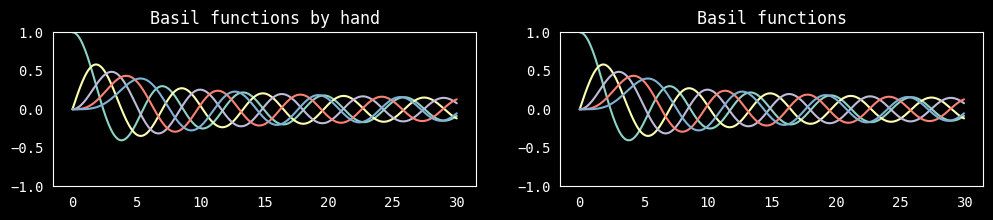

In [48]:
#bessel
def bes(m:int,x:np.ndarray):
    x_shape = x.shape
    return jv(m,x.reshape(-1)).reshape(x_shape)

def bes_zeros(m:int,n:int):
    if m == 0: return jn_zeros(m,n)
    else: return np.concatenate([[0], jn_zeros(m,n-1)])

# def bes(m:int,x:np.ndarray,n=70): # accurate until x ~ n+m
#     x_shape = x.shape
#     x = x.reshape(-1)
#     b = np.zeros_like(x)
#     for l in range(n):
#         b += (-1)**l * (x/2)**(2*l+m) / (fact(l)*fact(l+m))
#     return b.reshape(x_shape)

#plot
r = np.linspace(0, 30, 300)
plt.figure(figsize=(12,2))
plt.subplot(121)
for m in range(5):
    plt.plot(r, bes(m,r), label=f'm={m}')
plt.ylim(-1,1)
plt.grid()
plt.title('Basil functions by hand')

# plot the first bessel functions
plt.subplot(122)
for m in range(5):
    plt.plot(r, jn(m,r), label=f'm={m}')
plt.ylim(-1,1)
plt.grid()
plt.title('Basil functions')
plt.show()

### Reconstructing the emiss $g(r,\theta)$ from the Bessel coefficients
$g^{c,s}_m(r) = \sum_{l=0}^{\infty} a^{c,s}_{ml} J_{m}(x_{ml}r)$ , with $x_{ml}$ the $l$-th root of the $m$-th Bessel function.

In complex form:
$g_m(r) = \sum_{l=0}^{\infty} a_{ml} J_{m}(x_{ml}r)$

$r, \theta$ are the spherical coordinates, $m$ is the harmonic, $c,s$ are the cosine and sine coefficients, $a$ are the Bessel coefficients, $J_m$ is the Bessel function of the first kind of order $m$.

Note on imaginary/aritmetic version of the Fourier series:
- $\sum_{m=-\infty}^{\infty} a_m e^{im\theta} = \sum_{m=-\infty}^{\infty} a^c_m \cos(m\theta) + i a^s_m \sin(m\theta)$
- $a^c_m = a_m + a_{-m} = 2 Re(a_m)$ 
- $a^s_m = i(a_m - a_{-m}) = 2 Im(a_m)$


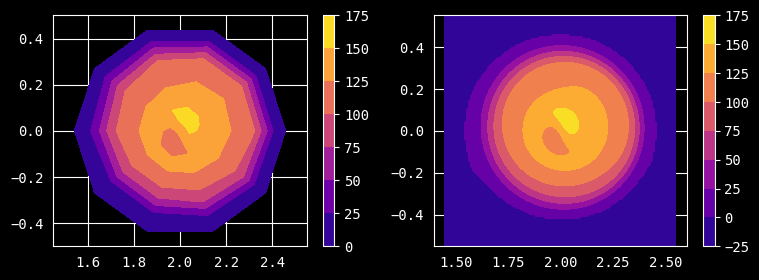

In [49]:
def calc_g(r, θ, a): # r: vector of radii, θ: vector of angles, a vector of coefficients (complex numbers)
    assert a.shape == (M,L) and a.dtype==complex, f'a.shape: {a.shape}, a.dtype: {a.dtype}'
    g = np.zeros((len(r), len(θ)), dtype=complex)
    for m in range(M):
        gm = np.dot(a[m], bes(m, r*bes_zeros(m, L)[:,None]))
        g += gm[:,None] * np.exp(1j*m*θ)
    return np.abs(g).T

r = np.linspace(0,1,FINESSE) # create a vector of radii
θ = np.linspace(0,2*π,FINESSE) # create a vector of angles

g = calc_g(r, θ, a)/MINR # calculate the g emissivity map

rr, θθ = np.meshgrid(r, θ) # create a meshgrid of r and θ
rθ = np.stack([rr, θθ], axis=-1)

xy = np.zeros_like(rθ) # convert to cartesian coordinates
xy[:,:,0] = rθ[:,:,0]*MINR * np.cos(rθ[:,:,1])
xy[:,:,1] = rθ[:,:,0]*MINR * np.sin(rθ[:,:,1]) 

#plot
plt.figure(figsize=(9,3))
cbar_min, cbar_max = np.min([np.min(g), np.min(emiss)]), np.max([np.max(g), np.max(emiss)])
xlm, xlM, ylm, ylM = np.min(xy_gt[:,:,0]), np.max(xy_gt[:,:,0]), np.min(xy_gt[:,:,1]), np.max(xy_gt[:,:,1])
plt.subplot(121)
plt.contourf(xy[:,:,0]+MAJR, xy[:,:,1], g)
plt.axis('equal')
plt.xlim(xlm, xlM); plt.ylim(ylm, ylM)
plt.colorbar()
plt.subplot(122)
plt.contourf(xy_gt[:,:,0], xy_gt[:,:,1], emiss)
plt.axis('equal')
plt.xlim(xlm, xlM); plt.ylim(ylm, ylM)
plt.colorbar()
plt.show()